In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os
from scipy.stats import describe, pearsonr

In [2]:
score_folder = './results/scores/'

# PPMI

In [3]:
ws_list = [1,2,3,5,7,10,12,200]
alpha_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
k_list = [1,1.5,2,3,4,5,6,8,10,15]

ranges = {'window_size':ws_list,'alpha':alpha_list,'k':k_list}

In [4]:
columns = ['window_size','alpha','k','rho','pvalue']
table = np.empty( ( len(ws_list)*len(alpha_list)*len(k_list) , len(columns)) )

In [5]:
i = 0
print('Records: {}'.format(table.shape[0]))
for ws in ws_list:
    for alpha in alpha_list:
        for k in k_list:
            file_name = f'count_ws{ws}/count_ws{ws}-ppmi_a{alpha}_k{k}'
            arr = np.genfromtxt(score_folder+file_name, delimiter='\t')
            if len(arr.shape)>1: #more than one line
                rho, pvalue = arr.mean(axis=0)
            else:
                rho, pvalue = arr
            table[i] = ( ws, alpha, k, rho, pvalue )
            i+=1
            print(f'\r{i}/{table.shape[0]}\t({np.round(i/table.shape[0]*100,2)}%)',end='')


Records: 800
800/800	(100.0%)

In [26]:
score_df = pd.DataFrame(table,columns=columns)
score_df['window_size'] = score_df['window_size'].astype('int16')
score_df

,window_size,alpha,k,rho,pvalue
0,1,0.1,1.0,0.03770,0.8247
1,1,0.1,1.5,0.02762,0.8711
2,1,0.1,2.0,0.00854,0.9600
3,1,0.1,3.0,0.01304,0.9389
4,1,0.1,4.0,0.01814,0.9151
...,...,...,...,...,...
795,200,1.0,5.0,0.19811,0.2398
796,200,1.0,6.0,0.19894,0.2378
797,200,1.0,8.0,0.17464,0.3012
798,200,1.0,10.0,0.18827,0.2644


In [107]:
score_df = pd.DataFrame(table,columns=columns)
score_df['window_size'] = score_df['window_size'].astype('int16')
score_df = score_df[score_df.window_size>1]

score_df['alpha_range']='Top (.6-1.0)'
score_df['k_range']='Top (8-10-15)'
score_df['ws_range']='Top (7-12)'

score_df.loc[(score_df.window_size<7),'ws_range']='Low (2-5)'
score_df.loc[(score_df.window_size==200),'ws_range']='Sentence (200)'

score_df.loc[(score_df.k<8),'k_range']='Mid (4-6)'
score_df.loc[(score_df.k<4),'k_range']='Low (1-3)'

#score_df.loc[(score_df.alpha<0.7),'alpha_range']='Mid (.5-.6)'
score_df.loc[(score_df.alpha<0.6),'alpha_range']='Low (.1-.5)'

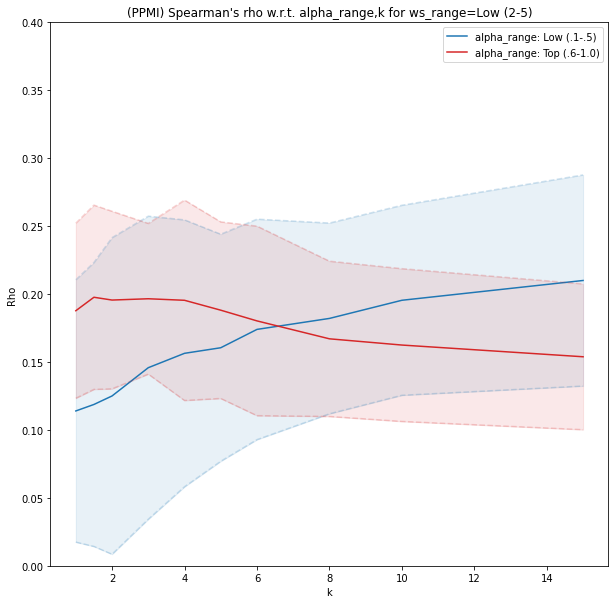

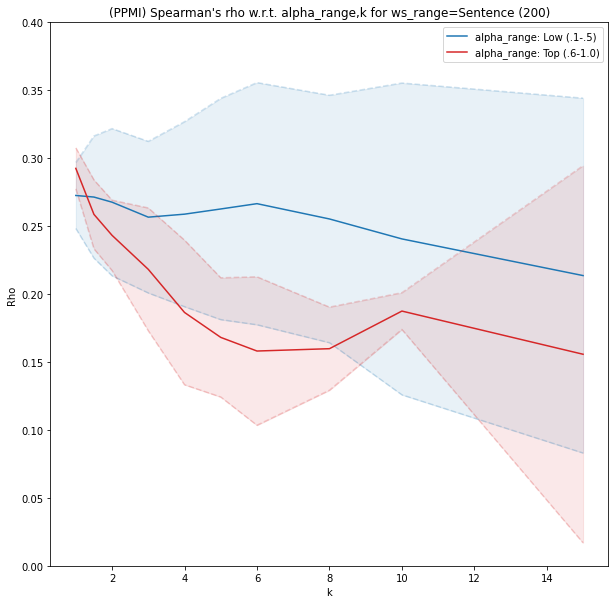

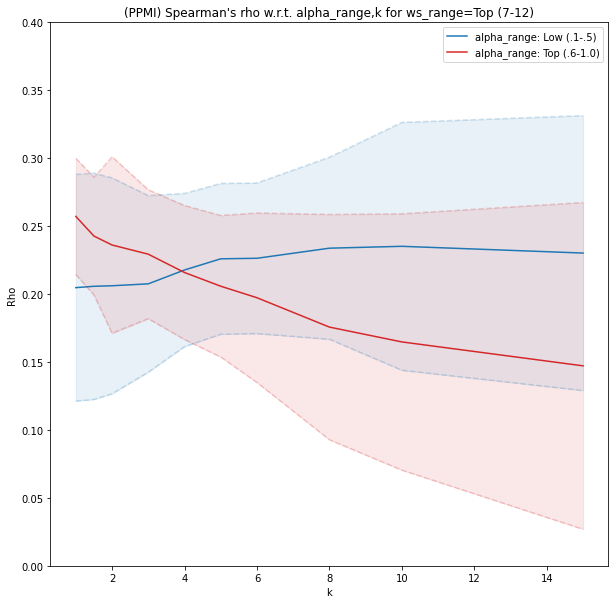

In [108]:
first_attribute = 'alpha_range'
second_attribute = 'k'
fixed_attribute = 'ws_range'
first_range = list(score_df.groupby(first_attribute).groups.keys())
second_range = list(score_df.groupby(second_attribute).groups.keys())
fixed_range = list(score_df.groupby(fixed_attribute).groups.keys())

colors = {'Low': 'tab:blue', 'Mid':'tab:orange' , 'Top':'tab:red' }

for fixed_value in fixed_range:
    group_df = score_df.groupby(fixed_attribute).get_group(fixed_value)
    subgroups = group_df.groupby(first_attribute)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    for first_value in first_range:
        c = colors[first_value[:3]]
        subgroup = subgroups.get_group(first_value)[['rho',second_attribute]]
        means = subgroup.groupby(second_attribute).agg(['mean']).rho['mean']
        errors = 2*subgroup.groupby(second_attribute).agg(['std']).rho['std']
        ax.plot(second_range,means,label=first_attribute+': '+str(first_value), color=c)
        ax.plot(second_range,means-errors,alpha=0.2,ls='--',color=c)
        ax.plot(second_range,means+errors,alpha=0.2,ls='--',color=c)
        ax.fill_between(second_range,means-errors,means+errors,alpha=0.1,color=c)

    ax.set_ylim([0,0.4])
    ax.set_title("(PPMI) Spearman's rho w.r.t. {},{} for {}={}".format(first_attribute,second_attribute,fixed_attribute,fixed_value))
    ax.set_xlabel(second_attribute)
    ax.set_ylabel('Rho')
    plt.legend()
    plt.savefig('results_img/{}_{}_({}{})_rho.png'.format(first_attribute,second_attribute,fixed_attribute,fixed_value),dpi=100,transparent=False)
plt.show()

In [28]:
score_df

,window_size,alpha,k,rho,pvalue,alpha_range,k_range,ws_range
0,1,0.1,1.0,0.03770,0.8247,Low,Low,Low
1,1,0.1,1.5,0.02762,0.8711,Low,Low,Low
2,1,0.1,2.0,0.00854,0.9600,Low,Low,Low
3,1,0.1,3.0,0.01304,0.9389,Low,Low,Low
4,1,0.1,4.0,0.01814,0.9151,Low,Low,Low
...,...,...,...,...,...,...,...,...
795,200,1.0,5.0,0.19811,0.2398,High,Mid,Sentence
796,200,1.0,6.0,0.19894,0.2378,High,Mid,Sentence
797,200,1.0,8.0,0.17464,0.3012,High,High,Sentence
798,200,1.0,10.0,0.18827,0.2644,High,High,Sentence


In [8]:
grp_ws = score_df.groupby('window_size')
grp_a = score_df.groupby('alpha')
grp_k = score_df.groupby('k')


In [9]:
grp_ws_desc = grp_ws.rho.agg(['mean','std','var','min','max'])
grp_a_desc = grp_a.rho.agg(['mean','std','var','min','max'])
grp_k_desc = grp_k.rho.agg(['mean','std','var','min','max'])
grp_ws_desc

,mean,std,var,min,max
window_size,,,,,
1,0.052467,0.026028,0.000677,-0.00516,0.12722
2,0.168822,0.053454,0.002857,0.03569,0.24969
3,0.150867,0.033717,0.001137,0.07588,0.26486
5,0.191183,0.043175,0.001864,0.09888,0.28229
7,0.194971,0.048829,0.002384,0.06418,0.30601
10,0.219322,0.039636,0.001571,0.06436,0.30826
12,0.225321,0.036926,0.001364,0.11145,0.31940
200,0.229639,0.053975,0.002913,0.05751,0.33600


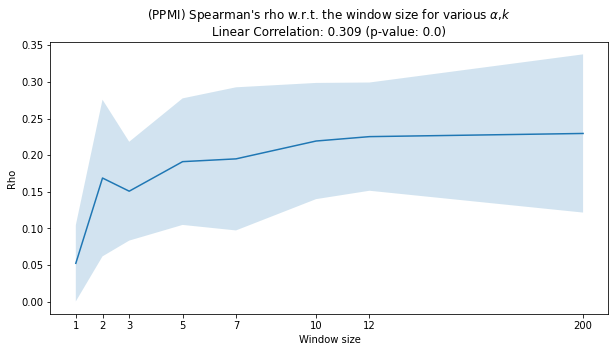

In [84]:
grp_ws_means = grp_ws_desc['mean']
grp_ws_error = 2*grp_ws_desc['std']
corr_r, corr_pvalue = pearsonr( score_df.window_size, score_df.rho )

ws_x = [1,2,3,5,7,10,12,20]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(ws_x,grp_ws_means)
ax.fill_between(ws_x,grp_ws_means-grp_ws_error,grp_ws_means+grp_ws_error,alpha=0.2)
ax.set_xticks(ws_x)
ax.set_xticklabels(ws_list)
ax.set_title("(PPMI) Spearman's rho w.r.t. the window size for various $\\alpha$,$k$\nLinear Correlation: {} (p-value: {})".format(corr_r.round(3),corr_pvalue.round(5)))
ax.set_xlabel('Window size')
ax.set_ylabel('Rho')
plt.savefig('results_img/ws_rho.png',dpi=100,transparent=False)
plt.show()

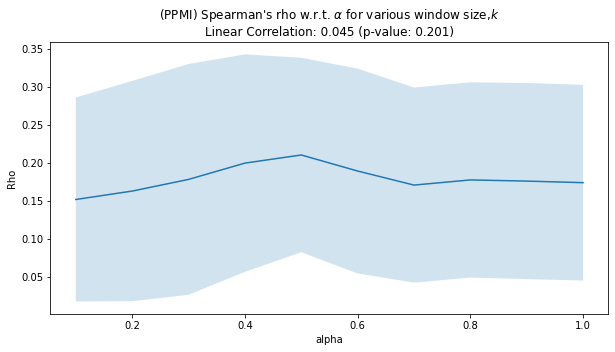

In [85]:
means = grp_a_desc['mean']
error = 2*grp_a_desc['std']
x = alpha_list
corr_r, corr_pvalue = pearsonr( score_df.alpha, score_df.rho )

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(x,means)
ax.fill_between(x,means-error,means+error,alpha=0.2)
ax.set_title("(PPMI) Spearman's rho w.r.t. $\\alpha$ for various window size,$k$\nLinear Correlation: {} (p-value: {})".format(corr_r.round(3),corr_pvalue.round(3)))
ax.set_xlabel('alpha')
ax.set_ylabel('Rho')
plt.savefig('results_img/alpha_rho.png',dpi=100,transparent=False)
plt.show()

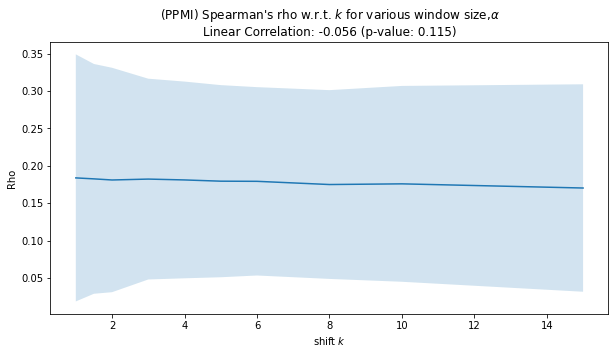

In [86]:
means = grp_k_desc['mean']
error = 2*grp_k_desc['std']
x = k_list
corr_r, corr_pvalue = pearsonr( score_df.k, score_df.rho )

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(x,means)
ax.fill_between(x,means-error,means+error,alpha=0.2)
ax.set_title("(PPMI) Spearman's rho w.r.t. $k$ for various window size,$\\alpha$\nLinear Correlation: {} (p-value: {})".format(corr_r.round(3),corr_pvalue.round(3)))
ax.set_xlabel('shift $k$')
ax.set_ylabel('Rho')
plt.savefig('results_img/k_rho.png',dpi=100,transparent=False)
plt.show()

In [42]:
first_value

'High'

In [44]:
score_df.ws_range.value_counts()

Low         500
High        200
Sentence    100
Name: ws_range, dtype: int64

In [66]:
score_df.groupby('ws_range').get_group('High').groupby('alpha_range').get_group('High').groupby('k').agg(['mean']).rho['mean']

k
1.0     0.258862
1.5     0.249704
2.0     0.246798
3.0     0.235834
4.0     0.230868
5.0     0.224038
6.0     0.216152
8.0     0.199656
10.0    0.187105
15.0    0.182301
Name: mean, dtype: float64

In [83]:
first_range

['Low (.1-.3)', 'Mid (.4-.6)', 'Top (.7-1.0)']

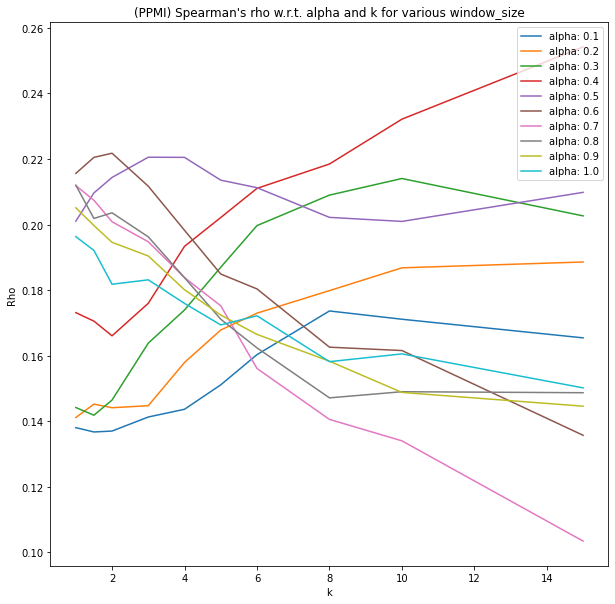

In [204]:
first_attribute = 'alpha'
second_attribute = 'k'
third_attribute = 'window_size'
first_range = list(score_df.groupby(first_attribute).groups.keys())
second_range = list(score_df.groupby(second_attribute).groups.keys())
third_range = list(score_df.groupby(third_attribute).groups.keys())

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

third_means = score_df.groupby(third_attribute).rho.agg(['mean'])['mean']
third_stds = score_df.groupby(third_attribute).rho.agg(['std'])['std']
    
groups = score_df.groupby(first_attribute)
for ind,first_value in enumerate(first_range):
    group = groups.get_group(first_value)
    subgroups = group.groupby(second_attribute)
    
    

    means = np.empty(len(second_range))
    errors = np.empty(len(second_range))
    
    for i,second_value in enumerate(second_range):
        series = subgroups.get_group(second_value).sort_values(third_attribute).set_index(third_attribute)['rho']
        #series = (series - third_means) / third_stds
        means[i] = series.mean()
        errors[i] = 2*series.std()

    c = colors[ind]
    ax.plot(second_range,means,label=first_attribute+': '+str(first_value),color=c)

    # ax.plot(second_range,means-errors,alpha=0.2,ls='--',color=c)
    # ax.plot(second_range,means+errors,alpha=0.2,ls='--',color=c)
    # ax.fill_between(second_range,means-errors,means+errors,alpha=0.1,color=c)
    

ax.set_title("(PPMI) Spearman's rho w.r.t. {} and {} for {}=".format(first_attribute,second_attribute,third_attribute))
ax.set_xlabel(second_attribute)
ax.set_ylabel('Rho')
plt.legend()
plt.savefig('results_img/{}_{}_{}_rho_wErrors.png'.format(first_attribute,second_attribute,third_attribute),dpi=100,transparent=False)
plt.show()

# SVD

In [6]:
ws_list = [5,10,200][:1]
alpha_list = [0.75,1.0]
k_list = [1,5]
dim_list = [100,300,512,1024]

ranges = {'window_size':ws_list,'alpha':alpha_list,'k':k_list,'d':dim_list}

In [10]:
columns = ['window_size','alpha','k','d','rho','pvalue']

In [13]:
i = 0
table = []
N = len(ws_list)*len(alpha_list)*len(k_list)*len(dim_list)
print('Records: {}'.format( N ))
for ws in ws_list:
    for alpha in alpha_list:
        for k in k_list:
            for d in dim_list:
                file_name = f'count_ws{ws}/count_ws{ws}-ppmi_a{alpha}_k{k}-svd_d{d}'
                arr = np.genfromtxt(score_folder+file_name, delimiter='\t')
                if len(arr.shape)>1: #more than one line
                    for row in arr:
                        rho, pvalue = row
                        table.append({'window_size':ws,
                                  'alpha':alpha,
                                  'k':k,
                                  'd':d,
                                  'rho':rho,
                                  'pvalue':pvalue
                                  })
                    
                else:
                    rho, pvalue = arr
                    table.append({'window_size':ws,
                                  'alpha':alpha,
                                  'k':k,
                                  'd':d,
                                  'rho':rho,
                                  'pvalue':pvalue
                                  })
                i+=1
                print(f'\r{i}/{N}\t({np.round(i/N*100,2)}%)',end='')


Records: 16
16/16	(100.0%)

In [14]:
score_df = pd.DataFrame(table,columns=columns)
score_df['window_size'] = score_df['window_size'].astype('int16')
score_df['d'] = score_df['d'].astype('int64')
score_df['k'] = score_df['k'].astype('int16')
score_df

,window_size,alpha,k,d,rho,pvalue
0,5,0.75,1,100,0.35699,0.0301
1,5,0.75,1,100,0.42753,0.0083
2,5,0.75,1,100,0.43192,0.0076
3,5,0.75,1,100,0.38260,0.0194
4,5,0.75,1,100,0.42694,0.0084
5,5,0.75,1,100,0.40963,0.0118
6,5,0.75,1,300,0.39018,0.0170
7,5,0.75,1,300,0.48219,0.0025
8,5,0.75,1,300,0.33505,0.0427
9,5,0.75,1,300,0.37430,0.0225


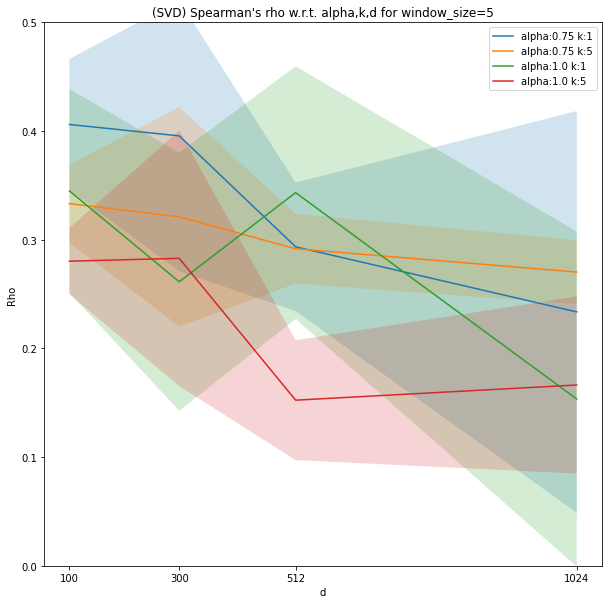

In [17]:
first_attribute = 'alpha'
second_attribute = 'k'
third_attribute = 'd'
fixed_attribute = 'window_size'
first_range = list(score_df.groupby(first_attribute).groups.keys())
second_range = list(score_df.groupby(second_attribute).groups.keys())
third_range = list(score_df.groupby(third_attribute).groups.keys())
fixed_range = list(score_df.groupby(fixed_attribute).groups.keys())

for fixed_value in fixed_range:
    group_df = score_df.groupby(fixed_attribute).get_group(fixed_value)
    subgroups = group_df.groupby(first_attribute)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    for first_value in first_range:
        subgroup = subgroups.get_group(first_value)[['rho',second_attribute, third_attribute]]
        subsubgroups = subgroup.groupby(second_attribute)
        for second_value in second_range:  
            subsubgroup = subsubgroups.get_group(second_value)[['rho', third_attribute]]
            means = subsubgroup.groupby(third_attribute).agg(['mean']).rho['mean']
            errors = 2*subsubgroup.groupby(third_attribute).agg(['std']).rho['std']
            ax.plot(third_range,means,label=f'{first_attribute}:{first_value} {second_attribute}:{second_value}')
            ax.fill_between(third_range,means-errors,means+errors,alpha=0.2)

    ax.set_ylim([0,0.5])
    ax.set_xticks(third_range)
    ax.set_title("(SVD) Spearman's rho w.r.t. {},{},{} for {}={}".format(first_attribute,second_attribute,third_attribute,fixed_attribute,fixed_value))
    ax.set_xlabel(third_attribute)
    ax.set_ylabel('Rho')
    plt.legend()
    plt.savefig('results_img/{}_{}_{}_({}{})_rho.png'.format(first_attribute,second_attribute,third_attribute,fixed_attribute,fixed_value),dpi=100,transparent=False)
plt.show()